## Query GPT-4 for name and analysis using a toy example

#### This uses an improved version of the original prompt that includes instructions to generate an LLM Confidence Score.

#### The prompt also includes an example analysis to help the LLM in its task.

#### The LLM Score has its own column in the output TSV file.

#### The JSON config file is updated to use "GPT-4_1106-preview" build.

In [75]:
import pandas as pd
import json 
from utils.openai_query import openai_chat
from utils.prompt_factory import make_user_prompt_with_score
from tqdm import tqdm
import openai
import os
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
## load variables
# Replace with your actual values
config_file = './jsonFiles/GOLLMrun_config.json'  # replace with your actual config file 
input_file = 'data/GO_term_analysis/toy_example_contaminated.csv' # replace with your actual input file
input_sep = ','  # replace with the separator
set_index = 'GO'  # replace with your column name that you want to set as index or None
gene_column = 'Genes'  # replace with your actual column name for the gene list
gene_sep = ' '  # replace with your actual separator
gene_features = None  # replace with your path to the gene features or None if you don't want to include in the prompt
direct = False # if True, then the prompt will be a direct sentence asking for a name and analysis from the gene set, otherwise default or customized prompt
out_file = 'data/GO_term_analysis/LLM_processed_toy_example_with_score'  # replace with your actual output file name
customized_prompt = False # if True, then the prompt will be the custom prompt, if False, then the prompt will use default

# load the config file
with open(config_file) as json_file:
    config = json.load(json_file)

if customized_prompt:
    # make sure the file exist 
    if os.path.isfile(config['CUSTOM_PROMPT_FILE']):
        with open(config['CUSTOM_PROMPT_FILE'], 'r') as f: # replace with your actual customized prompt file
            customized_prompt = f.read()
            assert len(customized_prompt) > 1, "Customized prompt is empty"
    else:
        print("Customized prompt file does not exist")
        customized_prompt = None
else:
    customized_prompt = None

# Load OpenAI key, context, and model used 
openai.api_key = os.environ["OPENAI_API_KEY"]

context = config['CONTEXT']
model = config['MODEL']
temperature = config['TEMP']
max_tokens = config['MAX_TOKENS']
rate_per_token = config['RATE_PER_TOKEN']
LOG_FILE = config['LOG_NAME']+'_log.json'
DOLLAR_LIMIT = config['DOLLAR_LIMIT']

SEED = 42

In [77]:
def get_llm_response(prompt, model, context, temperature, max_tokens, rate_per_token, LOG_FILE, DOLLAR_LIMIT):
    """
    Generates a prompt using the provided genes and retrieves the LLM response.

    Args:
        genes (list): List of genes to generate the prompt.
        model (str): Model identifier to use for generating the response.
        Additional arguments for the `openai_chat` function.

    Returns:
        tuple: Contains llm_name, llm_score, and llm_analysis.
    """
    try:
        analysis = None
        if model.startswith('gpt'):
            analysis, finger_print = openai_chat(context, prompt, model, temperature, max_tokens, rate_per_token, LOG_FILE, DOLLAR_LIMIT)

        if analysis:
            llm_process = analysis.split("\n")[0].replace("Process: ", "")
            
            llm_score = llm_process.split(" ")[-1].strip("()")
            
            llm_name = llm_process.rsplit(" ", 1)[0]
            
            llm_analysis = analysis.split('\n', 2)[2]
        else:
            llm_name, llm_score, llm_analysis = None, None, None

        return llm_name, llm_score, llm_analysis, finger_print
    except Exception as e:
        print(f"Error in get_llm_response: {e}")
        return None, None, None, None

def save_progress(df, response_dict, out_file):
    """
    Save DataFrame and LLM response dictionary to file.
    """
    df.to_csv(f'{out_file}.tsv', sep='\t', index=True)
    with open(f'{out_file}.json', 'w') as fp:
        json.dump(response_dict, fp)


In [78]:
df = pd.read_csv(input_file, sep = input_sep)
df.set_index(set_index, inplace=True)

geneset_columns = [col for col in df.columns if col.endswith('Genes')]

#initialize columns
for geneset in geneset_columns:
        if 'contaminated' in geneset:
            prefix = '_'.join(geneset.split('_')[:2])
            
            # initialize columns  
            df[prefix + '_LLM Name'] = None
            df[prefix + '_LLM Analysis'] = None
            df[prefix + '_LLM Score'] = None
        else:
            df['LLM Name'] = None
            df['LLM Analysis'] = None
            df['LLM Score'] = None
    
df.head()

,Genes,Gene_Count,Term_Description,50perc_contaminated_Genes,100perc_contaminated_Genes,LLM Name,LLM Analysis,LLM Score,50perc_contaminated_LLM Name,50perc_contaminated_LLM Analysis,50perc_contaminated_LLM Score,100perc_contaminated_LLM Name,100perc_contaminated_LLM Analysis,100perc_contaminated_LLM Score
GO,,,,,,,,,,,,,,
GO:0032385,LDLRAP1 SCP2D1 ANXA2 SCP2,4,positive regulation of intracellular cholester...,LDLRAP1 SCP2 TRIM45 NME5,HMGA2 MID2 HSFX2 FOXP4,None,None,None,None,None,None,None,None,None
GO:0002468,NOD1 HLA-DRA CLEC4A HLA-DRB1 CCL21 NOD2 CCL19 ...,15,dendritic cell antigen processing and presenta...,CD68 HLA-DRB3 CCL19 CCL21 HLA-DRA NOD2 THBS1 T...,JAG1 LTK ARL17A SLCO4A1 PLEKHO2 NDUFS5 ZC3H12D...,None,None,None,None,None,None,None,None,None
GO:0033683,OGG1 ERCC5 XPA ERCC4 NTHL1,5,"nucleotide-excision repair, DNA incision",XPA NTHL1 NAA11 SCD5 CDCA8,MBTPS2 PRCD BUB3 SLC13A1 FADS2,None,None,None,None,None,None,None,None,None
GO:0035672,SLC7A11 SLC25A39 SLC26A6 ABCB9 SLC15A4 ABCC5 C...,15,oligopeptide transmembrane transport,GJA1 SLC15A4 SLC15A1 CDH17 SLC25A39 SLC26A6 SL...,DEFB113 GLMN CELA2B SIGLEC7 RIGI CCL3L3 DEFB11...,None,None,None,None,None,None,None,None,None
GO:0048023,OPN3 CDH3 ATP7A APPL1 ASIP RAB38 ZEB2 TYRP1 GIPC1,9,positive regulation of melanin biosynthetic pr...,TYRP1 CDH3 OPN3 RAB38 FGFRL1 ZNF429 DUS3L CTSK...,WEE2 STIM1 EXOC4 MYO15A GLIPR1L1 ATAD3A CDCA5 ...,None,None,None,None,None,None,None,None,None


In [79]:

llm_response_dict = {}
i = 0 #used for track progress and saving the file
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    for geneset in geneset_columns:
        print(f"Processing {geneset}")
        genes = row[geneset].split()
        if len(genes) >1000:
            print(f'Gene set {i} has more than 1000 genes, skipping')
            continue
    
        try:
            if 'contaminated' in geneset:
                prefix = '_'.join(geneset.split('_')[:2])
                prompt = make_user_prompt_with_score(genes)
                llm_name, llm_score, llm_analysis, finger_print = get_llm_response(prompt, model, context, temperature, max_tokens, rate_per_token, LOG_FILE, DOLLAR_LIMIT)
                # initialize columns  
                df.loc[idx, prefix + '_LLM Name'] = llm_name
                df.loc[idx, prefix + '_LLM Analysis'] = llm_analysis
                df.loc[idx, prefix + '_LLM Score'] = float(llm_score)
                
                llm_response_dict[idx][prefix] = {'prompt': prompt, 
                                        'responses': llm_name + '\n' + llm_score + '\n' + llm_analysis,
                                            'finger_print': finger_print}
                    
            else:
                prompt = make_user_prompt_with_score(genes)
                llm_name, llm_score, llm_analysis, finger_print = get_llm_response(prompt, model, context, temperature, max_tokens, rate_per_token, LOG_FILE, DOLLAR_LIMIT)
                df.loc[idx, 'LLM Name'] = llm_name
                df.loc[idx, 'LLM Analysis'] = llm_analysis
                df.loc[idx, 'LLM Score'] = float(llm_score)

                llm_response_dict[idx][geneset] = {'prompt': prompt, 
                                        'responses': llm_name + '\n' + llm_score + '\n' + llm_analysis,
                                            'finger_print': finger_print}
       
        except Exception as e:
            print(f'Error for {idx}: {e}')
            llm_response_dict[idx] = {'prompt': prompt,
                                        'responses': None,
                                        'finger_print': None,
                                        'status': 'ERROR: '+str(e)}
            continue
    i += 1
    if i % 10 == 0:
        save_progress(df, llm_response_dict, out_file)
        print(f"Saved progress for {i} genesets")

  0%|          | 0/10 [00:00<?, ?it/s]

Processing Genes
1274
Error for GO:0032385: 'GO:0032385'
Processing 50perc_contaminated_Genes
1278
Processing 100perc_contaminated_Genes


 10%|█         | 1/10 [01:23<12:28, 83.20s/it]

1369
Processing Genes
1608
Error for GO:0002468: 'GO:0002468'
Processing 50perc_contaminated_Genes
1733
Processing 100perc_contaminated_Genes


 20%|██        | 2/10 [04:03<17:07, 128.40s/it]

1560
Processing Genes
1400
Error for GO:0033683: 'GO:0033683'
Processing 50perc_contaminated_Genes
1425
Processing 100perc_contaminated_Genes


 30%|███       | 3/10 [06:00<14:24, 123.52s/it]

1424
Processing Genes
1609
Error for GO:0035672: 'GO:0035672'
Processing 50perc_contaminated_Genes
1619
Processing 100perc_contaminated_Genes


 40%|████      | 4/10 [08:28<13:18, 133.10s/it]

1510
Processing Genes
1628
Error for GO:0048023: 'GO:0048023'
Processing 50perc_contaminated_Genes
1637
Processing 100perc_contaminated_Genes


 50%|█████     | 5/10 [10:48<11:17, 135.58s/it]

1473
Processing Genes
1315
Error for GO:0044029: 'GO:0044029'
Processing 50perc_contaminated_Genes
1301
Processing 100perc_contaminated_Genes


In [13]:
import pandas as pd 
score_df = pd.read_csv('data/GO_term_analysis/LLM_processed_toy_example_with_score.tsv', sep = '\t')
score_df

,GO,Genes,Gene_Count,Term_Description,50perc_contaminated_Genes,100perc_contaminated_Genes,LLM Name,LLM Analysis,LLM Score,50perc_contaminated_LLM Name,50perc_contaminated_LLM Analysis,50perc_contaminated_LLM Score,100perc_contaminated_LLM Name,100perc_contaminated_LLM Analysis,100perc_contaminated_LLM Score
0,GO:0032385,LDLRAP1 SCP2D1 ANXA2 SCP2,4,positive regulation of intracellular cholester...,LDLRAP1 SCP2 TRIM45 NME5,HMGA2 MID2 HSFX2 FOXP4,Lipid Metabolism and Transport,1. LDLRAP1 (Low-Density Lipoprotein Receptor A...,0.89,System of unrelated proteins,1. LDLRAP1 (Low-Density Lipoprotein Receptor A...,0.00,System of unrelated proteins,1. HMGA2 (High Mobility Group AT-hook 2) is a ...,0.00
1,GO:0002468,NOD1 HLA-DRA CLEC4A HLA-DRB1 CCL21 NOD2 CCL19 ...,15,dendritic cell antigen processing and presenta...,CD68 HLA-DRB3 CCL19 CCL21 HLA-DRA NOD2 THBS1 T...,JAG1 LTK ARL17A SLCO4A1 PLEKHO2 NDUFS5 ZC3H12D...,Immune Response and Antigen Presentation,1. NOD1 and NOD2 are intracellular pattern rec...,0.92,Immune Response and Antigen Presentation,1. CD68 is a glycoprotein highly expressed by ...,0.85,System of unrelated proteins,1. JAG1 is a ligand for multiple Notch recepto...,0.00
2,GO:0033683,OGG1 ERCC5 XPA ERCC4 NTHL1,5,"nucleotide-excision repair, DNA incision",XPA NTHL1 NAA11 SCD5 CDCA8,MBTPS2 PRCD BUB3 SLC13A1 FADS2,DNA Repair and Maintenance,1. OGG1 (8-oxoguanine DNA glycosylase) is invo...,0.98,DNA Repair and Cell Cycle Progression,"1. XPA (Xeroderma Pigmentosum, complementation...",0.80,System of unrelated proteins,1. MBTPS2 (Membrane-bound transcription factor...,0.00
3,GO:0035672,SLC7A11 SLC25A39 SLC26A6 ABCB9 SLC15A4 ABCC5 C...,15,oligopeptide transmembrane transport,GJA1 SLC15A4 SLC15A1 CDH17 SLC25A39 SLC26A6 SL...,DEFB113 GLMN CELA2B SIGLEC7 RIGI CCL3L3 DEFB11...,System of unrelated proteins,1. SLC7A11 is a component of the cystine/gluta...,0.00,System of unrelated proteins,"Analysis:\n\n1. GJA1, also known as Connexin 4...",0.00,System of unrelated proteins,1. DEFB113 and DEFB115 are members of the beta...,0.00
4,GO:0048023,OPN3 CDH3 ATP7A APPL1 ASIP RAB38 ZEB2 TYRP1 GIPC1,9,positive regulation of melanin biosynthetic pr...,TYRP1 CDH3 OPN3 RAB38 FGFRL1 ZNF429 DUS3L CTSK...,WEE2 STIM1 EXOC4 MYO15A GLIPR1L1 ATAD3A CDCA5 ...,System of unrelated proteins,"1. OPN3, also known as encephalopsin or panops...",0.00,Melanogenesis and Pigmentation Regulation,1. TYRP1 (Tyrosinase-related protein 1) is a m...,0.85,System of unrelated proteins,1. WEE2 (WEE family kinase 2) is a kinase invo...,0.00
5,GO:0044029,ZMPSTE24 NIBAN2 PIK3CA,3,hypomethylation of CpG island,ZMPSTE24 NLN PRPF6,BAP1 THAP11 TFAP4,Protein processing and cell survival signaling,1. ZMPSTE24 is a zinc metalloproteinase involv...,0.80,Pre-mRNA Splicing and Protein Maturation,1. ZMPSTE24 is a zinc metalloproteinase involv...,0.85,Chromatin Modification and Transcriptional Reg...,1. BAP1 (BRCA1 Associated Protein-1) is a deub...,0.85
6,GO:0048014,TEK ANGPT1 SVEP1 ANGPT2,4,Tie signaling pathway,SVEP1 TEK USF3 SUPT3H,CLEC19A AOC3 LRFN3 PITX2,Angiogenesis and Vascular Development,"1. TEK, also known as TIE2, is a receptor tyro...",0.95,System of unrelated proteins,"1. SVEP1 (Sushi, Von Willebrand Factor Type A,...",0.00,System of unrelated proteins,1. CLEC19A (C-type lectin domain family 19 mem...,0.00
7,GO:0010845,PRDM9 PRDM7 RAD51AP1 UBE2B,4,positive regulation of reciprocal meiotic reco...,PRDM7 UBE2B PSMC5 TMEM256,PLIN2 LRRC41 HSD17B12 BLOC1S3,Meiotic Chromosomal Dynamics and Genetic Recom...,1. PRDM9 is a histone methyltransferase that p...,0.85,System of unrelated proteins,1. PRDM7 (PR domain containing 7) is a member ...,0.00,Lipid Metabolism and Storage,"1. PLIN2, also known as Adipose Differentiatio...",0.85
8,GO:0050434,MDFIC RSF1 DHX9,3,positive regulation of viral transcription,MDFIC USF3 TAF13,FAXDC2 PNMT TRMO,Chromatin remodeling and RNA metabolism,1. MDFIC (MyoD Family Inhibitor Domain Contain...,0.85,System of unrelated proteins,1. MDFIC (MyoD Family Inhi

/tmp/ipykernel_3326282/1198259591.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')


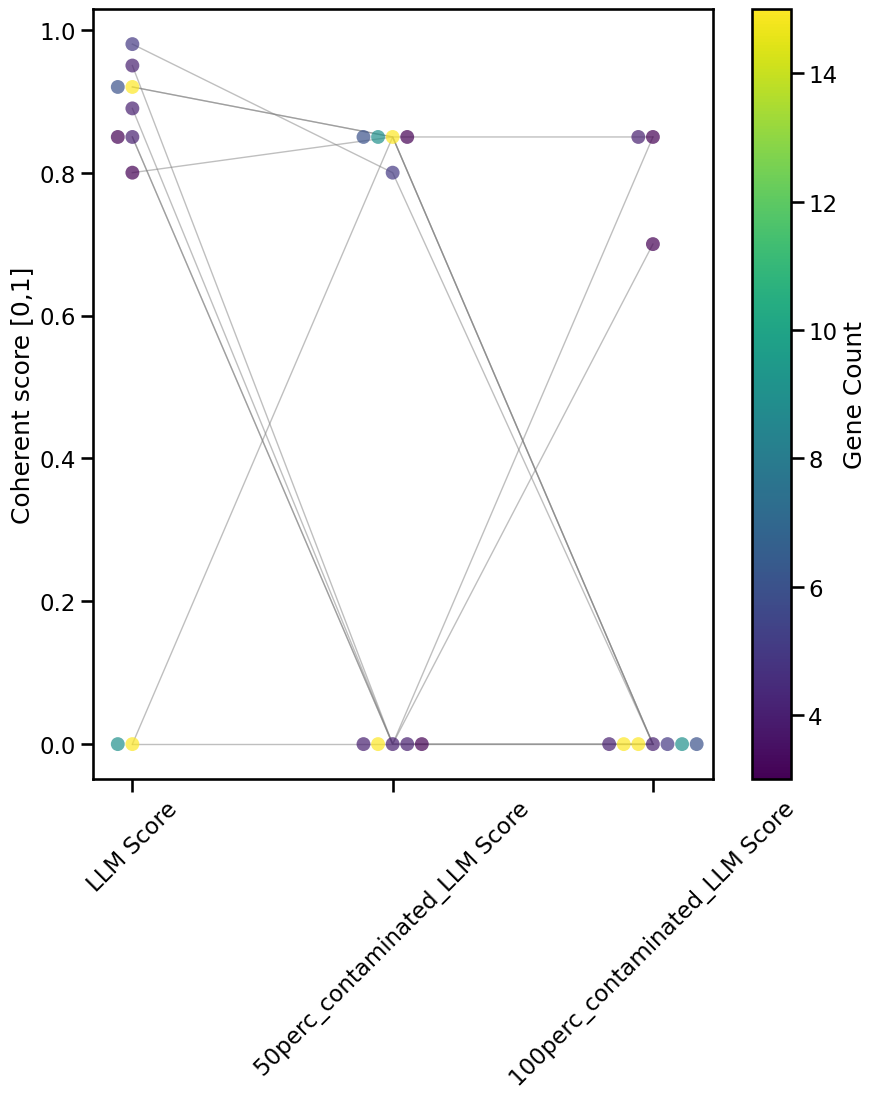

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
plt.figure(figsize=(10, 10))
columns_score = [col for col in score_df.columns if col.endswith('Score')]

filtered_score_df = score_df[['GO', 'Gene_Count']+columns_score]
long_scores = filtered_score_df.melt(id_vars=['GO', 'Gene_Count'], var_name='Score Type', value_name='Score')

long_scores.head()
long_scores.Score = long_scores.Score.astype(float)
sns.swarmplot(x='Score Type', y='Score', data=long_scores, size=10, hue='Gene_Count', palette='viridis', edgecolor='none', legend=False, alpha=0.7)

# Draw lines between points with the same 'GO'
for name, group in long_scores.groupby('GO'):
    if len(group) > 1:
        plt.plot(group['Score Type'], group['Score'], marker='', color='grey', linewidth=1, alpha=0.5)

plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Coherent score [0,1]')

# Create a colorbar for the continuous hue
norm = plt.Normalize(long_scores['Gene_Count'].min(), long_scores['Gene_Count'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Add the colorbar to the plot
plt.colorbar(sm, label='Gene Count')

plt.show()


In [50]:
import matplotlib.pyplot as plt
# plot the violin plot for the scores in a single plot
plt.figure(figsize=(20,10))
scores_columns = [col for col in df.columns if col.endswith('Score')]
for col in scores_columns:
    
        

AttributeError: 'tuple' object has no attribute 'endswith'

In [ ]:
# test the script for batch run

input_file = 'data/GO_term_analysis/toy_example.csv'
config = './jsonFiles/GOLLMrun_config.json'
%run query_llm_for_analysis.py --input $input_file --start 0 --end 1 --config $config

## Checkout and combine the output from the batch run 

In [ ]:
from glob import glob
import pandas as pd
import json

### sanity check code along the way
processed_files = glob('data/GO_term_analysis/LLM_processed_selected_go_terms*.tsv')

for file in processed_files:
    df = pd.read_csv(file, sep='\t')
    df.set_index('GO', inplace=True)
    ranges = file.split('/')[-1].split('.')[0].split('_')[5:7]
    with open(f'data/GO_term_analysis/LLM_response_go_terms_{ranges[0]}_{ranges[1]}.json') as fp:
        llm_response_dict = json.load(fp)
    for go_term, row in df.iterrows():
        if llm_response_dict[go_term] == 'NO ANALYSIS':
            print(file.split('/')[-1])
            print(f'No analysis for {go_term}')
            continue
        else:
            llm_analysis = llm_response_dict[go_term].split('\n', 2)[2]
            if df.loc[go_term, 'LLM Analysis'] != llm_analysis:
                print(f'LLM analysis for {go_term} is different')
            
    df.reset_index(inplace=True)
#     # print(ranges)
    print(df.shape)

    
combined_df = pd.concat([pd.read_csv(f, sep = '\t') for f in processed_files])
print(combined_df.shape)
print('Any duplicated GO: ',combined_df['GO'].duplicated().sum())
print('Any NAs in the LLM res: ', combined_df['LLM Name'].isna().sum())
print('Any duplicated LLM analysis: ', combined_df['LLM Analysis'].duplicated(keep=False).sum())

combined_df.to_csv('data/GO_term_analysis/LLM_processed_selected_1000_go_terms.tsv', index=False, sep='\t')